<a href="https://colab.research.google.com/github/iribarnesy/bot-among-us/blob/feat-add-players-recognition/Players_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Players detection - RetinaNet - Training and testing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install requirements

In [2]:
!pip install -U --pre tensorflow=="2.2.0"
# !pip install -U --pre tf-nightly

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

     |████████████████████████████████| 516.2MB 28kB/s 
     |████████████████████████████████| 460kB 55.0MB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
Cloning into 'models'...
remote: Enumerating objects: 2605, done.
remote: Counting objects: 100% (2605/2605), done.
remote: Compressing objects: 100% (2159/2159), done.
remote: Total 2605 (delta 649), reused 1257 (delta 412), pack-reused 0
Receiving objects: 100% (2605/2605), 32.57 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (649/649), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1647299 sha256=ec8de2d8e795fe4412329d860dd9f38d66168b562c22da612da98fda6e60055a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tubfz_if/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=848a5ad86990dfdba5ec89aa71a6b5ba96da092157ee83d391b4548b3c6530ed
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=21032c4679042ab3e5de895b818cf35541cdcc082994f3221348c5bc14348acc
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=76501a9a6ef162718b49abf74920a7ca9946e95f4420f55cc1fd

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


## Import requirements

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

## Initialize constants

In [15]:
ROOT_FOLDER = "/content/drive/Shareddrives/PFE_CHECK"
DATA_FOLDER = f"{ROOT_FOLDER}/BDD"
train_image_dir = f"{DATA_FOLDER}/positive_small"
test_image_dir = train_image_dir
annotation_file = "full-pos.txt"

MODEL_PATH = f"{ROOT_FOLDER}/all_boxes_model_40_batches"
MODEL_CHECKPOINT_PATH = f"{MODEL_PATH}/ckpt-1-1"

training = False

MIN_SCORE_THRESHOLD = 0.6

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

## Define util functions

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    min_score_thresh=MIN_SCORE_THRESHOLD):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


## Get images annotations/labels

In [7]:
import csv

annotation_file_path = f"{DATA_FOLDER}/{annotation_file}"

def get_box(row, index):
  """ a row is as below :
    image_path nb_boxes x1 y1 w1 h1 x2 y2 w2 h2...
  """
  xmin, ymin = int(row[index*4 + 2]), int(row[index*4 + 3])
  xmax, ymax = xmin + int(row[index*4 + 4]), ymin + int(row[index*4 + 5])
  xmin, ymin, xmax, ymax = xmin / 1920, ymin / 1080, xmax / 1920, ymax / 1080
  return [ymin, xmin, ymax, xmax]

gt_boxes = []
img_paths = []
with open(annotation_file_path) as annot_csv_file:
    csv_reader = csv.reader(annot_csv_file, delimiter=' ')
    line_count = 0
    for row in csv_reader:
      img_path = row[0].split('\\')[1]
      img_path = f"{train_image_dir}/{img_path}"
      nb_boxes = int(row[1])
      img_paths.append(img_path)
      boxes = np.array([get_box(row, i_box) for i_box in range(nb_boxes)], dtype=np.float32)
      gt_boxes.append(boxes)
      # print(f"img:{img_path}, nb_boxes:{nb_boxes}, boxes:{boxes}")
      line_count += 1
    print(f'Processed {line_count} lines.')
    # print(gt_boxes)

Processed 393 lines.


## Load images as numpy arrays

In [8]:
train_images_np = []
for img_path in tqdm(img_paths):
  train_images_np.append(load_image_into_numpy_array(img_path))

In [9]:
test_images_np = []

for filename in tqdm(os.listdir(test_image_dir)):
  image_path = os.path.join(test_image_dir +"/"+ filename)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))
  
print("Load test done !")

Load test done !


# Prepare data for training

Below we add the class annotations.  We also convert everything to the format that the training loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [10]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
player_class_id = 1
num_classes = 1

category_index = {player_class_id: {'id': player_class_id, 'name': 'player'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

print('Done preparing data.')

Done preparing data.


# Vizualize annotations

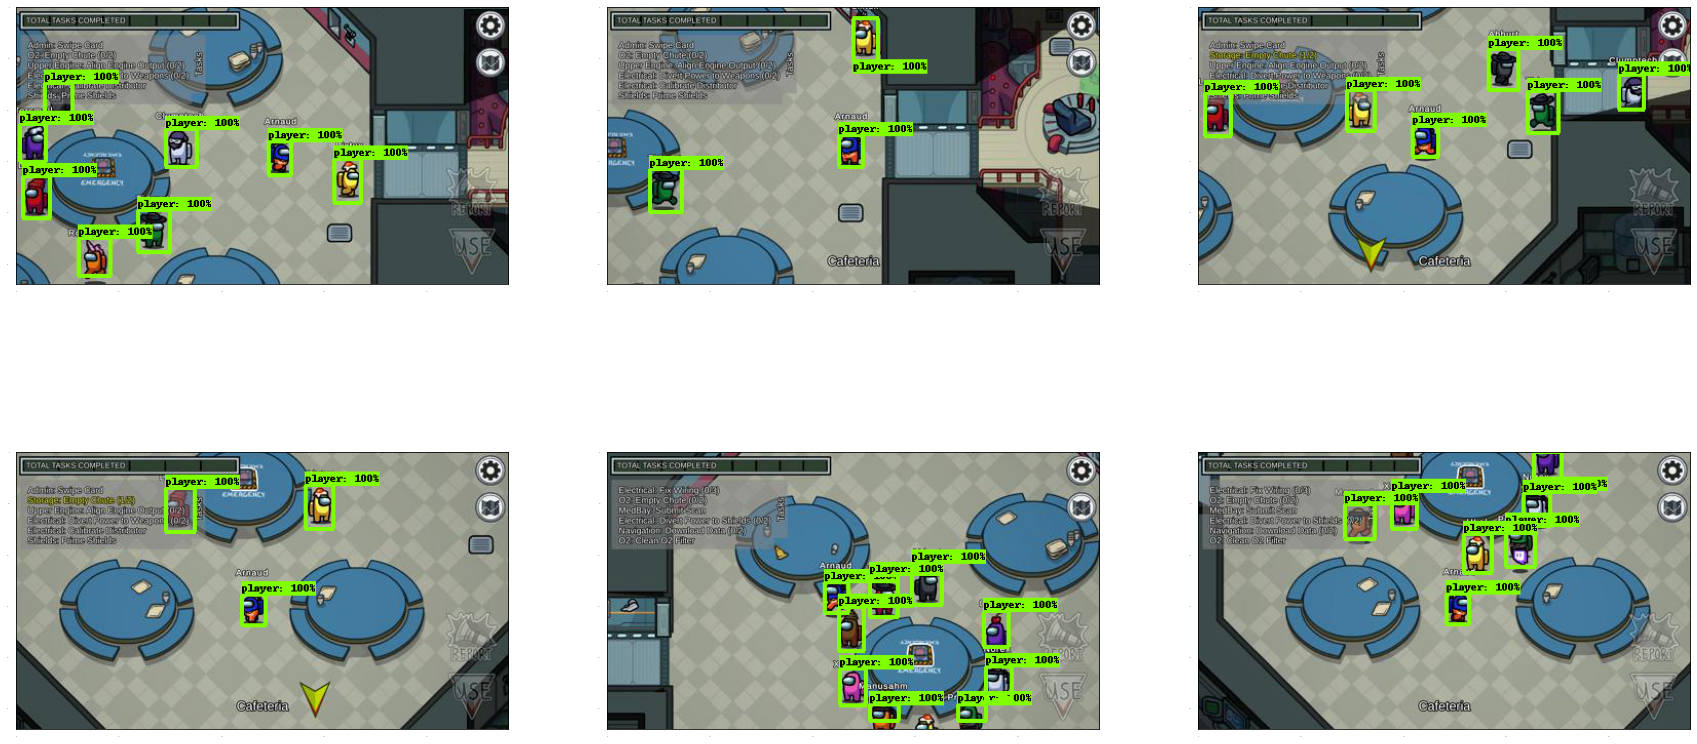

In [11]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.float32), 
      category_index)
plt.show()

# Create model and configure for training

In [12]:
if training:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
  !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [13]:
# !rm -r models/research/object_detection/test_data/*
# !rm -r ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/

In [16]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

if training:
  checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'
else:
  checkpoint_path = MODEL_CHECKPOINT_PATH

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=training)

if training:
  fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      # _prediction_heads=detection_model._box_predictor._prediction_heads,
        #  (i.e., the classification head that we *will not* restore)
      _box_prediction_head=detection_model._box_predictor._box_prediction_head,
      )
  fake_model = tf.compat.v2.train.Checkpoint(
            _feature_extractor=detection_model._feature_extractor,
            _box_predictor=fake_box_predictor)
  ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
else:
  ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [18]:
if training:
  tf.keras.backend.set_learning_phase(True)

  # These parameters can be tuned; since our training set has 5 images
  # it doesn't make sense to have a much larger batch size, though we could
  # fit more examples in memory if we wanted to.
  batch_size = 50
  learning_rate = 0.01
  num_batches = 20

  # Select variables in top layers to fine-tune.
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)

  # Set up forward + backward pass for a single train step.
  def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
      """A single training iteration.

      Args:
        image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
          Note that the height and width can vary across images, as they are
          reshaped within this function to be 640x640.
        groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
          tf.float32 representing groundtruth boxes for each image in the batch.
        groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
          with type tf.float32 representing groundtruth boxes for each image in
          the batch.

      Returns:
        A scalar tensor representing the total loss for the input batch.
      """
      shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
      model.provide_groundtruth(
          groundtruth_boxes_list=groundtruth_boxes_list,
          groundtruth_classes_list=groundtruth_classes_list)
      with tf.GradientTape() as tape:
        preprocessed_images = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
            for image_tensor in image_tensors], axis=0)
        prediction_dict = model.predict(preprocessed_images, shapes)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
      return total_loss

    return train_step_fn

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  train_step_fn = get_model_train_step_function(
      detection_model, optimizer, to_fine_tune)

  print('Start fine-tuning!', flush=True)
  for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Note that we do not do data augmentation in this demo.  If you want a
    # a fun exercise, we recommend experimenting with random horizontal flipping
    # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
      print('batch ' + str(idx) + ' of ' + str(num_batches)
      + ', loss=' +  str(total_loss.numpy()), flush=True)

  print('Done fine-tuning!')
else:
  print('No training done')

No training done


## Save the model & checkpoint

In [19]:
if training:
  ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
  tf.saved_model.save(detection_model, MODEL_PATH)
  save_path = ckpt.save(f"{MODEL_CHECKPOINT_PATH}")
  print(save_path)
else:
  print('No save done')

No save done


# Load test images and run inference with new model!

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


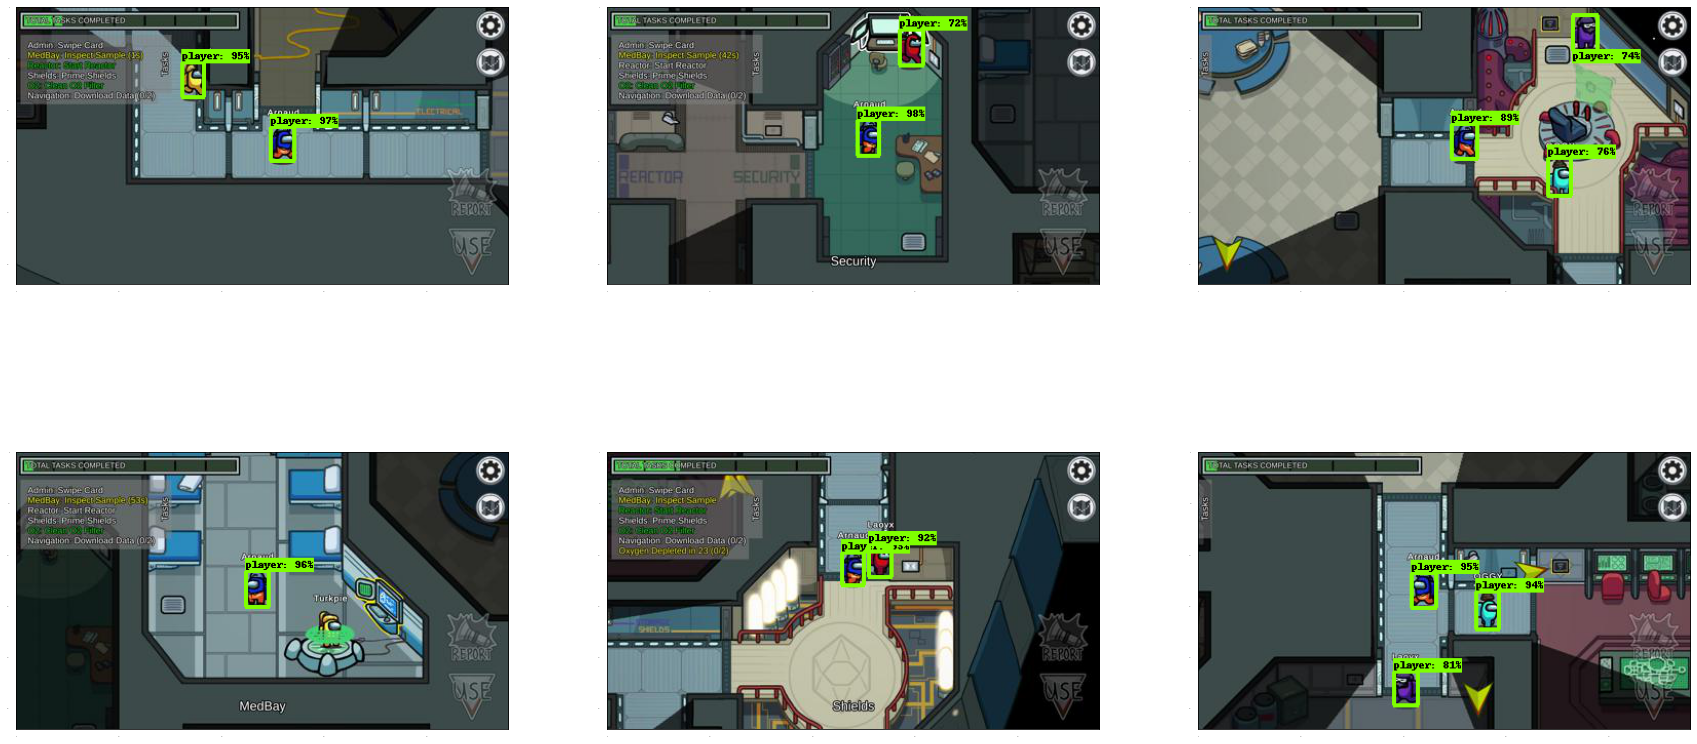

In [22]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

plt.figure(figsize=(30, 15))

label_id_offset = 1
image_index_offset = 6
for i in tqdm(range(len(test_images_np[:6]))):
  idx = i + image_index_offset
  input_tensor = tf.convert_to_tensor(test_images_np[idx], dtype=tf.float32)
  detections = detect(input_tensor)

  plt.subplot(2, 3, i+1)
  # print(train_images_np[i].shape)
  # print(gt_boxes[i].shape)
  # print(np.ones(shape=[gt_boxes[i].shape[0]], dtype=np.int32).shape)
  # print(dummy_scores.shape)
  plot_detections(
      test_images_np[idx][0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    # image_name="gif_frame_" + ('%02d' % i) + ".jpg",
    category_index, figsize=(15, 20))

plt.show()

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)2965504/4830080 bytes (61.4%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


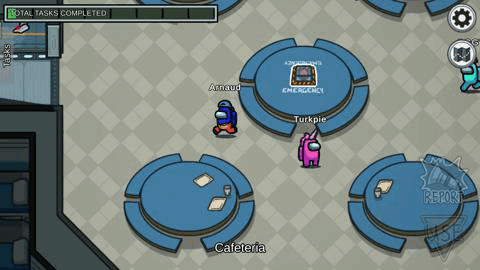

In [23]:
# imageio.plugins.freeimage.download()
# anim_file = 'among_test.gif'
# filenames = glob.glob('gif_frame_*.jpg')
# filenames = sorted(filenames)

# images = []
# for filename in filenames:
#   image = imageio.imread(filename)
#   images.append(image)

# imageio.mimsave(anim_file, images, 'GIF-FI', fps=2)

# display(IPyImage(open(anim_file, 'rb').read()))